In [202]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import pandas as pd
import time
import numpy as np
import pylab as plt
from mpl_toolkits.mplot3d import Axes3D

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [203]:
# own data set
df = pd.read_csv('./features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [204]:
columns_to_drop = ['label','filename', 'length']

def prepare_dataset(df, columns_to_drop, test_size, random_state):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    print(df.head())
    #perhaps can do a np.mean(df,axis=0) here.
    # divide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    #scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test

In [205]:
#Split Data into 70:30 train and test. 
X_train, y_train, X_test, y_test = prepare_dataset(df, columns_to_drop, test_size=0.3, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
#cast y data to one hot categorical
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
#can also use sparse_categorial instead, so save on converting to categorical one-hot
#print(y_train)
#print(y_test)

          filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.449060            85882.761315  ...   52.420910   
1              2039.036516        

In [206]:
def valid_callback(name):
    return [tf.keras.callbacks.EarlyStopping(monitor='val_ce', patience=20),
           tfdocs.modeling.EpochDots()]

In [207]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_ce', patience=20),
           tfdocs.modeling.EpochDots()]

In [208]:
def compile_and_fit(model, name, input_batchsize, max_epochs=50):
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.losses.CategoricalCrossentropy(from_logits=True, name='ce'),'accuracy'])
    
    time_epoch = time_for_epoch()
    #introduced callback time_epoch to time taken to train each epoch
    history = model.fit(X_train,  y_train, 
                        epochs=max_epochs, 
                        batch_size = input_batchsize,
                        callbacks=[time_epoch,tf.keras.callbacks.EarlyStopping                                 (monitor='val_ce', patience=20),
                        tfdocs.modeling.EpochDots()], 
                        validation_data=(X_test, y_test))
    # paras = np.array([min(history.history['val_loss']), 
    #                   max(history.history['val_accuracy']), 
    #                   sum(time_epoch.times)/len(time_epoch.times)])
    return history#paras

histories={}

In [209]:
class time_for_epoch(Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
te = time_for_epoch()

Epoch 1/50
700/700 [==============================] - 1s 672us/step - loss: 2.3235 - ce: 2.3235 - accuracy: 0.2000 - val_loss: 1.8643 - val_ce: 1.8643 - val_accuracy: 0.3567

Epoch: 0, accuracy:0.2000,  ce:2.3235,  loss:2.3235,  val_accuracy:0.3567,  val_ce:1.8643,  val_loss:1.8643,  
.Epoch 2/50
700/700 [==============================] - 0s 531us/step - loss: 1.7743 - ce: 1.7743 - accuracy: 0.3900 - val_loss: 1.6011 - val_ce: 1.6011 - val_accuracy: 0.4400
.Epoch 3/50
700/700 [==============================] - 0s 524us/step - loss: 1.5478 - ce: 1.5478 - accuracy: 0.4329 - val_loss: 1.4336 - val_ce: 1.4336 - val_accuracy: 0.4800
.Epoch 4/50
700/700 [==============================] - 0s 536us/step - loss: 1.4078 - ce: 1.4078 - accuracy: 0.4757 - val_loss: 1.3140 - val_ce: 1.3140 - val_accuracy: 0.5333
.Epoch 5/50
700/700 [==============================] - 0s 534us/step - loss: 1.3329 - ce: 1.3329 - accuracy: 0.5157 - val_loss: 1.2408 - val_ce: 1.2408 - val_accuracy: 0.5600
.Epoch 6/50
70

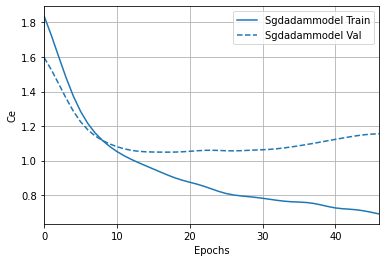

In [210]:
#Q1
SgdAdamModel = Sequential([
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

histories['SgdAdamModel'] = compile_and_fit(SgdAdamModel, 'SgdAdamModel',1)

plotter = tfdocs.plots.HistoryPlotter(metric = 'ce', smoothing_std=10)
plotter.plot(histories)

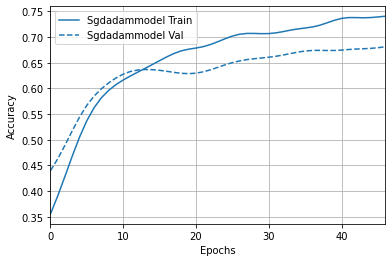

In [211]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(histories)


In [212]:
#Question 2
# compare the performance of the model using stochastic gradient
# descent and mini-batch gradient descent, as well as determining the optimal batch size
# for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient
# descent by training the neural network and evaluating the performances for different
# batch sizes. Note: Use 3-fold cross-validation on training partition to perform parameter
# selection

In [213]:
medianTimeTable = {}
def my_train(batch_size,model):

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.losses.CategoricalCrossentropy(from_logits=True, name='ce'),'accuracy'])
    
    time_epoch = time_for_epoch()
    #introduced callback time_epoch to time taken to train each epoch
    history = model.fit(X_train,  y_train, 
                        epochs=50, 
                        batch_size = batch_size,
                        callbacks=[time_epoch,tf.keras.callbacks.EarlyStopping(monitor='val_ce', patience=50),
                        tfdocs.modeling.EpochDots()], 
                        validation_data=(X_test, y_test))
    # SgdAdamModel.compile(optimizer='adam',
    #               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    #               metrics=[tf.keras.losses.CategoricalCrossentropy(from_logits=True, name='ce'),'accuracy'])
    
    # history = SgdAdamModel.fit(X_train, y_train,
    #                     batch_size=batch_size,
    #                     epochs= 50,
    #                     verbose=2,
    #                     use_multiprocessing=True,
    #                     callbacks = [te],
    #                     validation_data=(X_test, y_test))
    # plotter = tfdocs.plots.HistoryPlotter(metric = 'ce', smoothing_std=10)
    # plotter.plot(histories)
    print('median time for a weight update: %g s'%np.average(time_epoch.times))
    medianTimeTable[batch_size] = np.average(time_epoch.times)
    # paras = np.array([min(history.history['val_loss']), 
    #                   max(history.history['val_accuracy']), 
    #                   sum(te.times)/len(te.times)])
    
    # return paras
    return history

In [251]:
#K-FOLD     #test K FOLD integration 
num_folds = 3
cnt = 1
kf =KFold(n_splits=num_folds, random_state=None, shuffle=False)
XXTrain = X_train 
YYTrain = y_train
for train_index, test_index in kf.split(XXTrain,YYTrain):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = XXTrain[train_index], XXTrain[test_index]
    y_train, y_test = YYTrain[train_index], YYTrain[test_index]
    #test K FOLD integration very messy may want to remove
    histories ={}

    batch_sizes = [1,4,8,16,32,64]
    for batch in batch_sizes:
        MiniBatchModel = Sequential([
        Dense(16, activation='relu'),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])
    #train multiple models, save each model results into histories dictionary
    #name of each histories[key] must be different, to ensure different colours.
    #naming each model B(batch) + batch size 
        histories['B '+str(batch)+' K '+str(cnt)]= my_train(int(batch),MiniBatchModel)
        print(batch)
        #plot all results in histories dictionary according to metric, 'ce' 
        plotter = tfdocs.plots.HistoryPlotter(metric = 'ce', smoothing_std=10)
        plotter.plot(histories)
    # print('median time for a weight update: %g s'%np.average(te.times))
    cnt+=1

    print(medianTimeTable)

ValueError: k-fold cross-validation requires at least one train/test split by setting n_splits=2 or more, got n_splits=1.

Epoch 1/50
4/4 [==============================] - 1s 103ms/step - loss: 2.6326 - ce: 2.5117 - accuracy: 0.0817 - val_loss: 2.4486 - val_ce: 2.4682 - val_accuracy: 0.1442

Epoch: 0, accuracy:0.0817,  ce:2.5117,  loss:2.6326,  val_accuracy:0.1442,  val_ce:2.4682,  val_loss:2.4486,  
.Epoch 2/50
4/4 [==============================] - 0s 5ms/step - loss: 2.5843 - ce: 2.7154 - accuracy: 0.1202 - val_loss: 2.3880 - val_ce: 2.4054 - val_accuracy: 0.1538
.Epoch 3/50
4/4 [==============================] - 0s 5ms/step - loss: 2.6135 - ce: 2.6540 - accuracy: 0.1106 - val_loss: 2.3251 - val_ce: 2.3402 - val_accuracy: 0.1538
.Epoch 4/50
4/4 [==============================] - 0s 5ms/step - loss: 2.4934 - ce: 2.4441 - accuracy: 0.1106 - val_loss: 2.2672 - val_ce: 2.2805 - val_accuracy: 0.1635
.Epoch 5/50
4/4 [==============================] - 0s 5ms/step - loss: 2.4570 - ce: 2.3388 - accuracy: 0.1442 - val_loss: 2.2140 - val_ce: 2.2257 - val_accuracy: 0.1538
.Epoch 6/50
4/4 [=========================

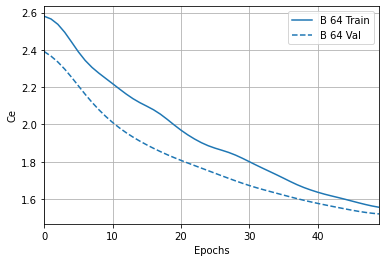

In [233]:
# a) Plot mean cross-validation accuracies over the training epochs for different
# batch sizes. Limit search space to batch sizes {1,4,8,16,32, 64}.
#history = {}

histories ={}

batch_sizes = [1,4,8,16,32,64]
for batch in batch_sizes:
    MiniBatchModel = Sequential([
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])
#train multiple models, save each model results into histories dictionary
#name of each histories[key] must be different, to ensure different colours.
#naming each model B(batch) + batch size 
histories['B '+str(batch)]= my_train(int(batch),MiniBatchModel)
print(batch)
#plot all results in histories dictionary according to metric, 'ce' 
plotter = tfdocs.plots.HistoryPlotter(metric = 'ce', smoothing_std=10)
plotter.plot(histories)
# print('median time for a weight update: %g s'%np.average(te.times))


print(medianTimeTable)
# #initialize multi threading to run my_train mini batch gradient descent on multiple batch sizes. 
# no_threads = mp.cpu_count()
# p = mp.Pool(processes = no_threads)
# print("start training")
# paras = p.map(my_train, batch_sizes)

# paras = np.array(paras)
# entropy, accuracy, time_epoch = paras[:,0], paras[:,1], paras[:, 2]

# plt.figure(1)
# plt.plot(range(len(batch_sizes)), time_epoch)
# plt.xticks(range(len(batch_sizes)), batch_sizes)
# plt.xlabel('batch size')
# plt.ylabel('time (ms)')
# plt.title('time for an epoch vs. batch size')
# plt.savefig('./figures/average_time_one_epoch.png')

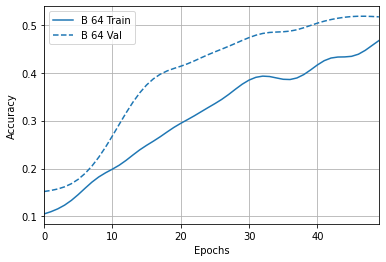

In [234]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(histories)

In [235]:
# b) Create a table of median time taken to train the network for one epoch
# against different batch sizes.

In [236]:
# c) Select the optimal batch size and state reasons for your selection.
#4 as seen from graph, train and test converge, and have most decent accuracy. 

In [237]:
# d) What is the difference between mini-batch gradient descent and stochastic
# gradient descent and what does this mean for model training?
# .. it faster. 

In [238]:
# e) Plot the train and test accuracies against epochs for the optimal batch size.
# 
#   plt.figure(2)
#   plt.plot(range(len(batch_sizes)), accuracy)
#   plt.xticks(range(len(batch_sizes)), batch_sizes)
#   plt.xlabel('batch size')
#   plt.ylabel('test accuracy')
#   plt.title('test accuracy vs. batch size')
#   plt.savefig('./figures/4.5b_2.png') 

In [239]:
#Question 3 Cross Validation accuracies against training epochs for different number of hidden layer neurons


/50
52/52 [==============================] - 0s 763us/step - loss: 0.9090 - ce: 0.9090 - accuracy: 0.6587 - val_loss: 1.2583 - val_ce: 1.2583 - val_accuracy: 0.5962
.Epoch 39/50
52/52 [==============================] - 0s 782us/step - loss: 0.8365 - ce: 0.8365 - accuracy: 0.7019 - val_loss: 1.2568 - val_ce: 1.2568 - val_accuracy: 0.6058
.Epoch 40/50
52/52 [==============================] - 0s 763us/step - loss: 0.8394 - ce: 0.8394 - accuracy: 0.6923 - val_loss: 1.2578 - val_ce: 1.2578 - val_accuracy: 0.5865
.Epoch 41/50
52/52 [==============================] - 0s 763us/step - loss: 0.8833 - ce: 0.8833 - accuracy: 0.6731 - val_loss: 1.2578 - val_ce: 1.2578 - val_accuracy: 0.5865
.Epoch 42/50
52/52 [==============================] - 0s 900us/step - loss: 0.8391 - ce: 0.8391 - accuracy: 0.6779 - val_loss: 1.2629 - val_ce: 1.2629 - val_accuracy: 0.5769
.Epoch 43/50
52/52 [==============================] - 0s 743us/step - loss: 0.7880 - ce: 0.7880 - accuracy: 0.7260 - val_loss: 1.2622 - val

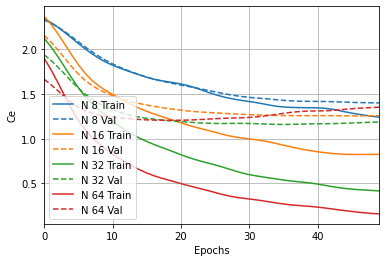

In [240]:
histories ={}

neurons_numbers = [8,16,32,64]
for currentNeuronNum in neurons_numbers:
    NeuronModel = Sequential([
    Dense(currentNeuronNum, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])
#train multiple models, save each model results into histories dictionary
#name of each histories[key] must be different, to ensure different colours.
#naming each model B(batch) + batch size 
    histories['N '+str(currentNeuronNum)]= my_train(4,NeuronModel)
    print(currentNeuronNum)
#plot all results in histories dictionary according to metric, 'ce' 
plotter = tfdocs.plots.HistoryPlotter(metric = 'ce', smoothing_std=10)
plotter.plot(histories)

In [241]:
#3b
#Optimal number of neurons is : 32
# This is due to the result as shown on the graph,where the ce for the test set is minimal when number of neurons is 32

Epoch 1/50
52/52 [==============================] - 0s 2ms/step - loss: 2.5591 - ce: 2.5591 - accuracy: 0.1971 - val_loss: 2.0710 - val_ce: 2.0710 - val_accuracy: 0.3365

Epoch: 0, accuracy:0.1971,  ce:2.5591,  loss:2.5591,  val_accuracy:0.3365,  val_ce:2.0710,  val_loss:2.0710,  
.Epoch 2/50
52/52 [==============================] - 0s 802us/step - loss: 2.1957 - ce: 2.1957 - accuracy: 0.2740 - val_loss: 1.8502 - val_ce: 1.8502 - val_accuracy: 0.4038
.Epoch 3/50
52/52 [==============================] - 0s 763us/step - loss: 1.9001 - ce: 1.9001 - accuracy: 0.3510 - val_loss: 1.7146 - val_ce: 1.7146 - val_accuracy: 0.4327
.Epoch 4/50
52/52 [==============================] - 0s 763us/step - loss: 1.6753 - ce: 1.6753 - accuracy: 0.4183 - val_loss: 1.6150 - val_ce: 1.6150 - val_accuracy: 0.4327
.Epoch 5/50
52/52 [==============================] - 0s 764us/step - loss: 1.5743 - ce: 1.5743 - accuracy: 0.4279 - val_loss: 1.5354 - val_ce: 1.5354 - val_accuracy: 0.4712
.Epoch 6/50
52/52 [=======

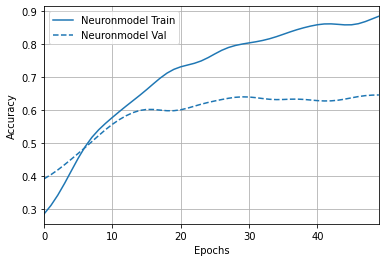

In [242]:
#3c
histories ={}

NeuronModel = Sequential([
Dense(32, activation='relu'),
Dropout(0.3),
Dense(10, activation='softmax')
])
histories['NeuronModel']= my_train(4,NeuronModel)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(histories)


In [243]:
#3d , we could possibly tune the drop off etc..

Epoch 1/50
208/208 [==============================] - 0s 1ms/step - loss: 2.4747 - ce: 2.4747 - accuracy: 0.1154 - val_loss: 2.1209 - val_ce: 2.1209 - val_accuracy: 0.2788

Epoch: 0, accuracy:0.1154,  ce:2.4747,  loss:2.4747,  val_accuracy:0.2788,  val_ce:2.1209,  val_loss:2.1209,  
.Epoch 2/50
208/208 [==============================] - 0s 597us/step - loss: 2.0541 - ce: 2.0541 - accuracy: 0.2212 - val_loss: 1.8863 - val_ce: 1.8863 - val_accuracy: 0.4135
.Epoch 3/50
208/208 [==============================] - 0s 602us/step - loss: 1.8088 - ce: 1.8088 - accuracy: 0.3606 - val_loss: 1.6981 - val_ce: 1.6981 - val_accuracy: 0.4327
.Epoch 4/50
208/208 [==============================] - 0s 612us/step - loss: 1.6088 - ce: 1.6088 - accuracy: 0.4183 - val_loss: 1.5813 - val_ce: 1.5813 - val_accuracy: 0.4904
.Epoch 5/50
208/208 [==============================] - 0s 626us/step - loss: 1.6295 - ce: 1.6295 - accuracy: 0.3894 - val_loss: 1.5679 - val_ce: 1.5679 - val_accuracy: 0.4904
.Epoch 6/50
208/

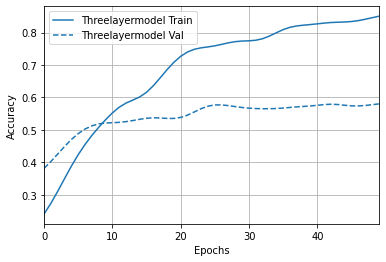

In [244]:
#4)a  3-layer network with two hiddenlayers with ReLU activation, each consisting of the optimal number of neurons you
#obtained in Question 3, (apply a dropout with a probability of 0.3 for each hidden layer),
#and train it with a batch size of 1
histories ={}

ThreeLayerModel = Sequential([
Dense(32, activation='relu'),
Dropout(0.3),
Dense(32, activation='relu'),
Dropout(0.3),
Dense(10, activation='softmax')
])
histories['ThreeLayerModel']= my_train(1,ThreeLayerModel)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(histories)

In [245]:
#4b
# 2 layer network with hyperparameter tuning seem to perform better than the 3 layer network with previous paramaters. 

Epoch 1/50
208/208 [==============================] - 0s 997us/step - loss: 2.4501 - ce: 2.4501 - accuracy: 0.1490 - val_loss: 2.1411 - val_ce: 2.1411 - val_accuracy: 0.2500

Epoch: 0, accuracy:0.1490,  ce:2.4501,  loss:2.4501,  val_accuracy:0.2500,  val_ce:2.1411,  val_loss:2.1411,  
.Epoch 2/50
208/208 [==============================] - 0s 573us/step - loss: 1.8504 - ce: 1.8504 - accuracy: 0.3221 - val_loss: 1.7488 - val_ce: 1.7488 - val_accuracy: 0.3750
.Epoch 3/50
208/208 [==============================] - 0s 573us/step - loss: 1.5741 - ce: 1.5741 - accuracy: 0.4231 - val_loss: 1.5599 - val_ce: 1.5599 - val_accuracy: 0.5000
.Epoch 4/50
208/208 [==============================] - 0s 578us/step - loss: 1.4039 - ce: 1.4039 - accuracy: 0.5048 - val_loss: 1.4413 - val_ce: 1.4413 - val_accuracy: 0.5481
.Epoch 5/50
208/208 [==============================] - 0s 593us/step - loss: 1.2640 - ce: 1.2640 - accuracy: 0.5529 - val_loss: 1.3564 - val_ce: 1.3564 - val_accuracy: 0.5673
.Epoch 6/50
20

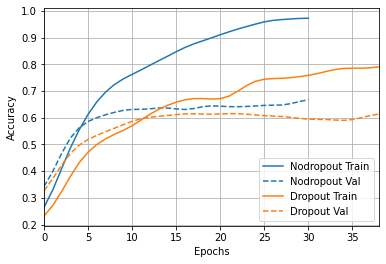

In [246]:
#5)a
histories ={}
SgdAdamModel = Sequential([
    Dense(16, activation='relu'),
    Dense(10, activation='softmax')
])

histories['NoDropout'] = compile_and_fit(SgdAdamModel, 'SgdAdamModel',1)

SgdAdamModel2 = Sequential([
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

histories['Dropout'] = compile_and_fit(SgdAdamModel2, 'SgdAdamModel',1)
# plotter = tfdocs.plots.HistoryPlotter(metric = 'ce', smoothing_std=10)
# plotter.plot(histories)

plotter2 = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter2.plot(histories)

print(histories)

In [247]:
#5b Effect of moving dropout is that the gap between train and test is amplified. Hence the model is overfitting when dropout is not applied. 
#5c We can also use the regularized technique to reduce the overfitting issue. 

In [248]:
#Conclusions
# It is facinating that by simply tuning the hyper parameters and implementing the models we are able to build a decent classifier that is generic and will work for almost any type of data
# the techniques learnt in this course have many possible applications in the wider world and it is truly amazing what we will be